In [49]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 2853 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
4367.53


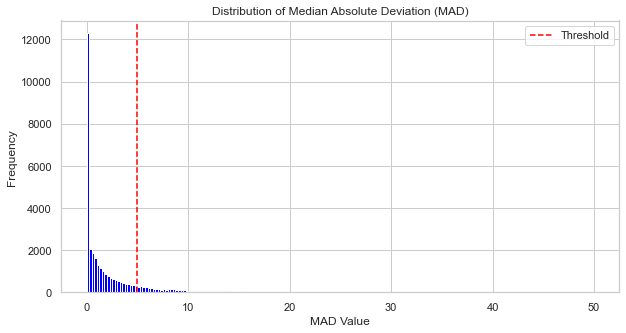

removing 28318 genes under the MAD threshold from the dataset
number of genes selected :  5953
log(1 + x) transformation...
scaling to [0, 1]...
1.0
number of seq in the dataset : 2853
keeping sample as is, no conversion to time series


In [68]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 5, 
    retain_phases="Both", 
    normalization = False,
    as_time_series = False,
    log1p = True,
    MT_removal = True,
    min_max = True)
                                                                    


In [71]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 32

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder._name = "FC_autoencoder"

In [72]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=30, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [13]:
%tensorboard --logdir ../workfiles/logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [75]:
hist = autoencoder.fit(x_train, epochs=20, callbacks=cb) # around 4 hours
#hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb) # around 4 hours

Epoch 1/20
45/45 [==============================] - 8s 154ms/step - loss: 0.3548 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 7s 154ms/step - loss: 0.0130 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 6s 126ms/step - loss: 0.0125 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 7s 168ms/step - loss: 0.0125 - lr: 0.0010
Epoch 5/20
45/45 [==============================] - 6s 142ms/step - loss: 0.0124 - lr: 0.0010
Epoch 6/20
45/45 [==============================] - 6s 143ms/step - loss: 0.0118 - lr: 0.0010
Epoch 7/20
45/45 [==============================] - 5s 103ms/step - loss: 0.0101 - lr: 0.0010
Epoch 8/20
45/45 [==============================] - 5s 110ms/step - loss: 0.0096 - lr: 0.0010
Epoch 9/20
45/45 [==============================] - 6s 129ms/step - loss: 0.0096 - lr: 0.0010
Epoch 10/20
45/45 [==============================] - 5s 117ms/step - loss: 0.0097 - lr: 0.0010
Epoch 11/20
45/45 [==============================] - 5s 109

Keeping in mind that outputting a constant solution for every observation yields a loss value of ~0.2 for MT removed, log1p transformed dataset.

benchmarking model : FC_autoencoder
number of parametters of the model: 13522496
shape of the dataset: (2853, 5953)
the dataset meets the min_max requirement
loss: 0.008133218
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,13522496,0.002833,NaN,NaN
1,FC_autoencoder,13522496,0.002833,NaN,NaN
2,FC_autoencoder,13522496,0.002833,NaN,NaN
3,FC_autoencoder,13522496,0.002826,NaN,NaN
4,FC_autoencoder,13522496,0.002810,NaN,NaN
5,FC_autoencoder,13522496,0.002810,NaN,NaN
6,FC_autoencoder,13522496,0.002810,NaN,NaN
7,FC_autoencoder,13522496,0.002810,5953.0,5953.0
8,FC_autoencoder,13522496,0.002810,2853.0,5953.0
0,FC_autoencoder,13522496,0.008133,2853.0,5953.0


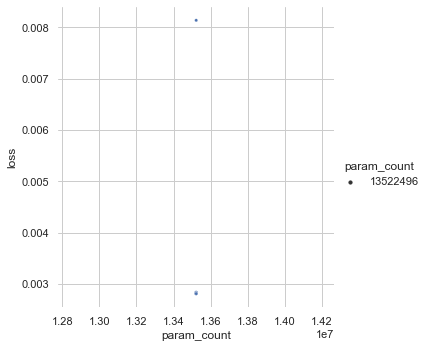

In [76]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train, 0)

In [53]:
autoencoder.load_weights(checkpoint_filepath)


[592561.375, 177429.0625, 85942.515625, 60302.91796875, 52137.9921875, 49055.24609375, 46181.13671875, 42778.328125, 39710.57421875, 37644.69140625, 36634.86328125, 39879.64453125, 35371.95703125, 34153.5234375, 31450.529296875, 29040.412109375, 28160.8046875, 25512.1875, 24469.69140625, 23284.84765625, 22718.318359375, 21036.173828125, 21629.439453125, 19099.470703125, 18541.44140625, 18976.451171875, 18183.484375, 14885.1328125, 14019.2646484375, 14012.5205078125, 14735.1328125, 15437.6064453125, 15790.337890625, 15679.517578125, 15504.8193359375, 15995.326171875, 16438.712890625, 16284.2216796875, 17397.271484375, 18147.69921875, 14610.8994140625, 12498.3310546875, 11550.705078125, 11346.0888671875, 11317.00390625, 11175.333984375, 11035.1494140625, 11036.7783203125, 11288.2978515625, 11495.939453125, 12023.48046875, 12865.298828125, 13019.9228515625, 13498.482421875, 13346.650390625, 12476.0517578125, 12151.93359375, 11322.173828125, 12140.1962890625, 13093.12890625, 11883.53125, 1

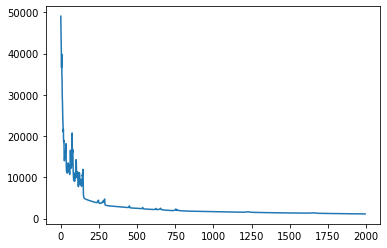

In [54]:
plt.plot(hist.history['loss'][5:])
print(hist.history['loss'])




### some diagnosis

In [78]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [57]:
autoencoder.encoder.save('../workfiles/simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


In [58]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

23/23 [==============================] - 0s 7ms/step


In [59]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames["name"]

In [60]:
df.to_csv("../workfiles/FC_ae.csv", index=False)


90/90 [==============================] - 0s 4ms/step


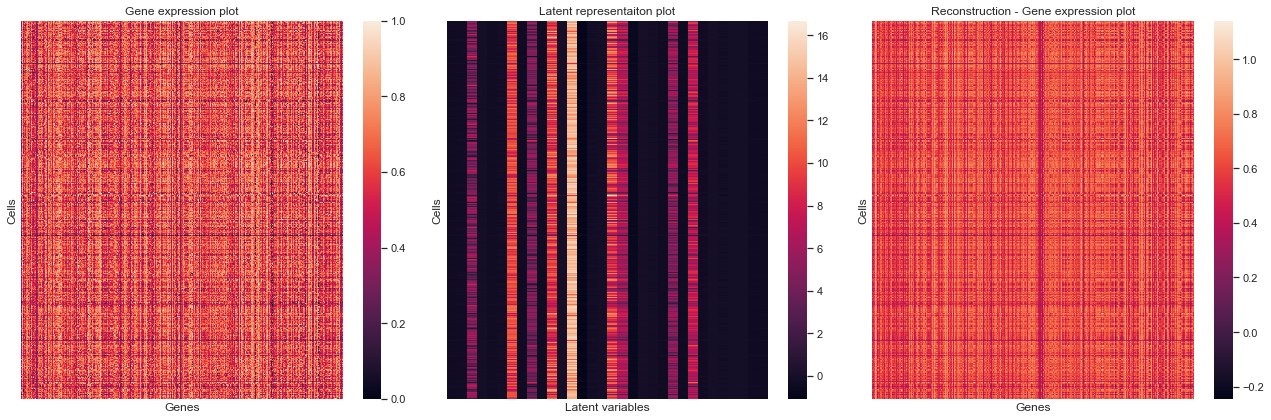

In [83]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)